In [1]:
!pip install --quiet git+https://github.com/EgorDudyrev/paspailleur.git
import caspailleur as csp
from paspailleur import pattern_structures as PS

In [2]:
from importlib import reload

In [3]:
from script import clustering as clib, visual_lib as vlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from functools import reduce
from bitarray import frozenbitarray

# Test examples on Circles data

## Step 1. Get the data

In [5]:
from sklearn import datasets

n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
X, y = noisy_circles

## Step 2. Setup pattern structures
For numerical columns, setup the grid of intervals that is not too general and not too precise

In [6]:
linscale_x = np.linspace(X[:,0].min()-0.01, X[:,0].max()+0.01, 11)
linscale_y = np.linspace(X[:,1].min()-0.01, X[:,1].max()+0.01, 11)

ps = PS.CartesianPS([PS.IntervalPS(values=linscale_x), PS.IntervalPS(values=linscale_y)])
data = list(ps.preprocess_data(X))

## Step 3. Mine stable concepts
Stable concepts are individual clusters of similar (but not too much) objects 

In [7]:
min_support = 0.01
min_delta_stability = 0.01

In [8]:
attributes, attr_extents = zip(*ps.iter_attributes(data, min_support=min_support))
print(len(attributes))

38


In [9]:
%%time
stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_gsofia(
    attr_extents,
    n_objects=len(data), min_delta_stability=min_delta_stability, min_supp=min_support,
    use_tqdm=True, n_attributes=len(attributes)
)
stable_extents = sorted(stable_extents, key=lambda ext: ext.count(), reverse=True)
print(f"n extents", len(stable_extents))

  0%|          | 0/38 [00:00<?, ?it/s]

n extents 1729
CPU times: user 52 ms, sys: 13.1 ms, total: 65.1 ms
Wall time: 65.4 ms


### Step 4. Find all minimal covering clusterings

In [10]:
n_clusters_max = 4

Filter out too similar clusters to simplify the search space

In [11]:
from bitarray.util import count_and, count_or

jaccard_thold = 0.85
min_added_coverage = 100
sparse_extents = []
for i, extent in enumerate(stable_extents):
    if extent.count() < min_added_coverage:
        continue
        
    not_like_others = all(count_and(extent, other)/count_or(extent, other) <= jaccard_thold
                          for other in sparse_extents)
    if not_like_others:
        sparse_extents.append(extent)
print(len(stable_extents), len(sparse_extents))

1729 372


Find the clusterings

In [12]:
%%time
clusterings = list(clib.mine_clusterings(sparse_extents, min_support=450, max_length=n_clusters_max,
                                         min_added_coverage=min_added_coverage))
print('n clusterings:', len(clusterings))
print('max found cluster size', max(map(len, clusterings)))

n clusterings: 2795
max found cluster size 4
CPU times: user 4.49 s, sys: 45.9 ms, total: 4.54 s
Wall time: 4.54 s


## Step 5. Choose the "optimal" clustering

In [13]:
clib = reload(clib)

In [14]:
concepts_dict = clib.mine_clusters_info(sparse_extents, attr_extents, ps, data)
concepts_df = pd.DataFrame(concepts_dict)
concepts_df.head()

,extent,intent,delta_stability,support,frequency,intent_human,level,density
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","((-1.08, 1.08, (BoundStatus.RCLOSED, BoundStat...",22,500,1.000,"x0: [-1.08, 1.08], x1: [-1.16, 1.11]",0,101.974221
1,"[0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","((-1.08, 0.86, (BoundStatus.RCLOSED, BoundStat...",22,424,0.848,"x0: [-1.08, 0.86], x1: [-1.16, 0.89]",2,106.613025
2,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","((-0.86, 1.08, (BoundStatus.RCLOSED, BoundStat...",22,419,0.838,"x0: [-0.86, 1.08], x1: [-1.16, 0.89]",2,105.355796
3,"[0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","((-0.86, 0.86, (BoundStatus.RCLOSED, BoundStat...",22,415,0.830,"x0: [-0.86, 0.86], x1: [-1.16, 1.11]",1,106.290339
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","((-1.08, 1.08, (BoundStatus.RCLOSED, BoundStat...",40,412,0.824,"x0: [-1.08, 1.08], x1: [-0.94, 0.66]",1,119.212963


In [15]:
clusterings_df = pd.DataFrame([clib.evaluate_clustering_measures(idxs, concepts_dict) for idxs in clusterings],
                              index=pd.Series(clusterings, name='clustering'))
clusterings_df.head()

,coverage,overlap,size,imbalance,stability,complexity,density
clustering,,,,,,,
"(0,)",500,0,1,0.000000,22.0,0.0,101.974221
"(8, 10)",500,271,2,14.849242,28.5,1.0,112.246681
"(8, 28)",500,201,2,64.346717,28.5,1.0,109.565118
"(8, 71)",500,134,2,111.722871,27.0,1.0,106.406498
"(8, 127)",500,84,2,147.078210,23.0,1.0,105.474539


In [16]:
clusterings_df_norm = (clusterings_df-clusterings_df.min())/(clusterings_df.max()-clusterings_df.min())
clusterings_df_norm.describe().loc[['min', 'max']]

,coverage,overlap,size,imbalance,stability,complexity,density
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
weight_params = dict(
    overlap_weight=2,
    size_weight=0.1, # old "n_concepts_weight"
    imbalance_weight=2,
    stability_weight=1,
    complexity_weight=0.5,
    density_weight=5
)

signs = np.array([1 if f in {'coverage', 'stability', 'density'} else -1 for f in clusterings_df_norm])
weights = np.array([1 if f == 'coverage' else weight_params[f"{f}_weight"] for f in clusterings_df_norm])
clusterings_df['reward'] = (clusterings_df_norm*weights*signs).sum(1)

In [18]:
clusterings_df = clusterings_df.sort_values('reward', ascending=False)
clusterings_df.head()

,coverage,overlap,size,imbalance,stability,complexity,density,reward
clustering,,,,,,,,
"(256, 264, 295, 314)",478,16,4,8.660254,15.75,2.0,122.008070,4.442504
"(273, 295, 314, 337)",453,13,4,8.266398,14.50,2.0,123.408890,4.147968
"(264, 273, 295, 314)",475,13,4,7.071068,14.25,2.0,120.481818,4.092800
"(273, 295, 314, 340)",452,13,4,8.655441,14.25,2.0,123.128149,4.064926
"(257, 295, 314, 337)",472,0,4,10.739336,13.00,2.0,119.572382,3.883036


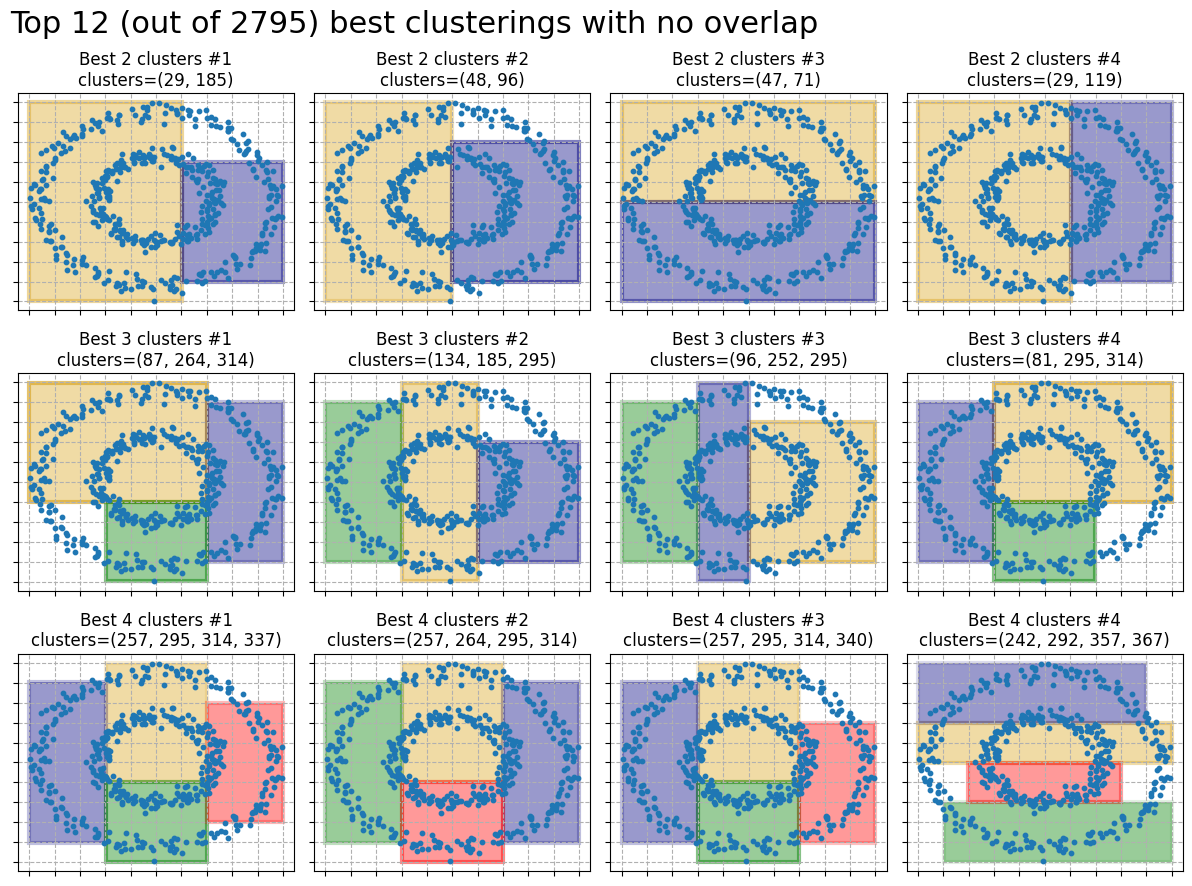

In [ ]:
fig, axs = plt.subplots(clusterings_df['size'].max()-1, 4, figsize=(12, 9))

for row_idx, n_clusters in enumerate(range(2, clusterings_df['size'].max()+1)):
    flg = (clusterings_df['size']==n_clusters)&(clusterings_df['overlap']==0)
    best_clusterings = clusterings_df[flg]
    for i, (ax, best_clustering) in enumerate(zip(axs[row_idx], best_clusterings.index)):
        vlib.init_axis(ax, f"Best {n_clusters} clusters #{i+1}\nclusters={best_clusterings.index[i]}", 
                       linscale_x, linscale_y, [], [],#range(len(linscale_x)), range(len(linscale_y)), 
                       grid_params=dict(zorder=0, linestyle='--'))

        ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
        vlib.draw_clustering(ax, best_clustering, concepts_df)

fig.suptitle(f'Top {len(axs.flatten())} (out of {len(clusterings_df)}) best clusterings with no overlap',
             size=22, ha='left', x=0.01)
fig.tight_layout()
fig.subplots_adjust()
# ax.legend(loc='lower right')
#fig.savefig('../figures/best_clustersNOLAP_blops.pdf')
plt.show()